In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import geoplot
from datetime import datetime
from math import sin, cos, sqrt, atan2, radians

def calculate_distance(row):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(row.pickup_latitude)
    lon1 = radians(row.pickup_longitude)
    lat2 = radians(row.dropoff_latitude)
    lon2 = radians(row.dropoff_longitude)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance*1000 # in metres

In [2]:
def remove_outlier_IQR(df, colname): # Remove outliers using 1.5IQR Method
    colname_describe = df[colname].describe()

    IQR = colname_describe['75%'] - colname_describe['25%'] 

    df_cleaned = \
    df.copy()\
    .loc[lambda x: x[colname] < colname_describe['75%'] + 1.5 * IQR]\
    .loc[lambda x: x[colname] > colname_describe['25%'] - 1.5 * IQR]
    
    return df_cleaned


In [3]:
df = pd.read_csv('../data/train.csv')

In [4]:
df.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


# Create Features (Predictors)

In [5]:
# Distance
df['distance'] = df.apply(calculate_distance, axis = 1)

# Convert to datetime
df.pickup_datetime = df.pickup_datetime.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df.dropoff_datetime = df.dropoff_datetime.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

# Extract day, month, year, hour, minute
df['pickup_day'] = df.pickup_datetime.apply(lambda x: x.day)
df['pickup_month'] = df.pickup_datetime.apply(lambda x: x.month)
df['pickup_year'] = df.pickup_datetime.apply(lambda x: x.year)
df['pickup_dayofweek'] = df.pickup_datetime.apply(lambda x: x.dayofweek)
df['pickup_weekday'] = df.pickup_datetime.apply(lambda x: x.weekday())
df['pickup_hour'] = df.pickup_datetime.apply(lambda x: x.hour)
df['pickup_minute'] = df.pickup_datetime.apply(lambda x: x.minute)

# Extract day, month, year, hour, minute
df['dropoff_day'] = df.dropoff_datetime.apply(lambda x: x.day)
df['dropoff_month'] = df.dropoff_datetime.apply(lambda x: x.month)
df['dropoff_year'] = df.dropoff_datetime.apply(lambda x: x.year)
df['dropoff_dayofweek'] = df.dropoff_datetime.apply(lambda x: x.dayofweek)
df['dropoff_weekday'] = df.dropoff_datetime.apply(lambda x: x.weekday())
df['dropoff_hour'] = df.dropoff_datetime.apply(lambda x: x.hour)
df['dropoff_minute'] = df.dropoff_datetime.apply(lambda x: x.minute)

In [6]:
X = ['distance',
    'pickup_day', 'pickup_month', 'pickup_year', 'pickup_dayofweek', 'pickup_weekday', 'pickup_hour', 'pickup_minute',
    'dropoff_day', 'dropoff_month', 'dropoff_year', 'dropoff_dayofweek', 'dropoff_weekday', 'dropoff_hour', 'dropoff_minute']

y = ['trip_duration']

In [7]:
df.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_weekday,pickup_hour,pickup_minute,dropoff_day,dropoff_month,dropoff_year,dropoff_dayofweek,dropoff_weekday,dropoff_hour,dropoff_minute
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0,17,24,14,3,2016,0,0,17,32
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6,0,43,12,6,2016,6,6,0,54
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,1,11,35,19,1,2016,1,1,12,10


# Check and Remove Outliers

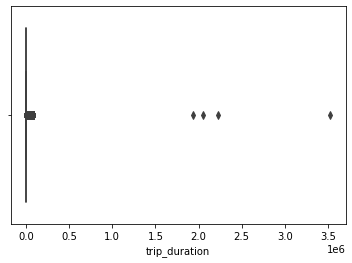

In [8]:
sns.boxplot(df.trip_duration)

In [9]:
df_cleaned = remove_outlier_IQR(df, 'trip_duration')

## Can also use leverage values or distance values for regression

In [10]:
print("{} Outliers removed".format(df.shape[0] - df_cleaned.shape[0]))

74324 Outliers removed


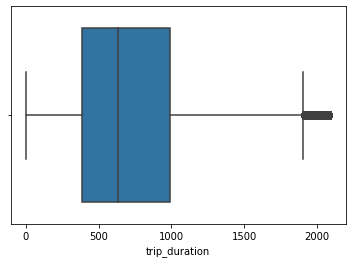

In [11]:
sns.boxplot(df_cleaned.trip_duration)

## Visualize on Map

In [12]:
max_longitude = max(max(df_cleaned.pickup_longitude), max(df_cleaned.dropoff_longitude))
min_longitude = min(min(df_cleaned.pickup_longitude), min(df_cleaned.dropoff_longitude))

max_latitude = max(max(df_cleaned.pickup_latitude), max(df_cleaned.dropoff_latitude))
min_latitude = min(min(df_cleaned.pickup_latitude), min(df_cleaned.dropoff_latitude))

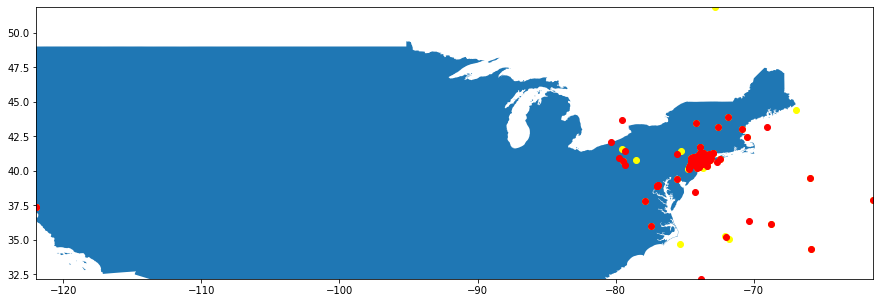

In [13]:
us_map = gpd.read_file("../data/map/cb_2018_us_nation_5m.shp")
fig, ax = plt.subplots(figsize = (15, 15))
us_map.plot(ax = ax)

# Show Boundary Box
ax.set_xlim((min_longitude, max_longitude))
ax.set_ylim((min_latitude, max_latitude))

# Plot pickup

#plt.scatter(data = df_locations_2, x = 'pickup_latitude', y= 'pickup_longitude',
#           c = 'green')


plt.scatter(data = df_cleaned\
                          , x = 'pickup_longitude', y= 'pickup_latitude',
           c = 'yellow')

# Plot dropoff
plt.scatter(data = df_cleaned\
                          , x = 'dropoff_longitude', y= 'dropoff_latitude',
           c = 'red')

plt.show()

In [16]:
df_cleaned.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_weekday,pickup_hour,pickup_minute,dropoff_day,dropoff_month,dropoff_year,dropoff_dayofweek,dropoff_weekday,dropoff_hour,dropoff_minute
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0,17,24,14,3,2016,0,0,17,32
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6,0,43,12,6,2016,6,6,0,54
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2,19,32,6,4,2016,2,2,19,39


## One Hot Encoding

In [15]:
from sklearn.preprocessing import OneHotEncoder

pickup_day_enc = OneHotEncoder(drop = 'first')
pickup_day_ohe = pickup_day_enc.fit_transform(df_cleaned['pickup_day'].values.reshape(-1, 1))


ValueError: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
 The old behavior is not compatible with the `drop` parameter. Instead, you must manually specify "categories='auto'" if you wish to use the `drop` parameter on an array of entirely integer data. This will enable the future behavior.

In [ ]:
pickup_day_ohe

# Build Regression Model

In [ ]:
## X : Day, Month, Hour, Minute --> Weekdays, Weekends, Holidays, 
## X : Distance from lat lon
## y : Duration

## Inference
## Check Assumptions for OLS
## Collinearity (Pairwise scatter plots, or pearson R2)/ multi-collinearity (VIF)
## Autocorrelation (Index residual plot)
## Error is normal with mean 0 and constant variance (QQ plot, standardize residual plot)

## T tests, F tests
## Coefficients (Hard to read for interactions terms/ polynomial expansion)


## Prediction
## Check Test Error


In [ ]:
ls = [1,2,3]

In [27]:
from sklearn.linear_model import LinearRegression

df_train, df_test= np.split(df_cleaned, [int(.7*len(df_cleaned))])
model = LinearRegression()
model.fit(df_train["pickup_longitude"].values.reshape(-1, 1), df_train["trip_duration"])
r_sq = model.score(df_train["pickup_longitude"].values.reshape(-1, 1), df_train["trip_duration"])
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

#y_pred = model.predict(df_test["pickup_longitude"])

coefficient of determination: 0.01377418262354013
intercept: 107876.74374553337
slope: [1448.36281059]
